## 📌 Step 4: Return Forecasting Using Lag-Based Baseline Models

### Objective
Assess whether short-term stock returns can be predicted using historical information, using NVIDIA as a representative example.

This step establishes a **realistic baseline** for return predictability before attempting more advanced models.

---

## 🔹 Stock Selection & Data Preparation

### Selected Stock
- **NVIDIA (NVDA)**

### Rationale
- Long trading history
- High liquidity
- Exhibits strong volatility clustering and regime shifts

### Preparation Steps
- Filter dataset for the selected stock
- Sort observations chronologically
- Retain log returns as the target variable

Log returns are preferred due to their statistical stability and widespread use in financial modeling.

---

## 🔹 Time-Aware Train/Test Split

### Method
- 80% of observations used for training
- 20% reserved for testing
- No shuffling to avoid look-ahead bias

### Why This Matters
Financial time-series data must preserve temporal order to ensure valid out-of-sample evaluation.

---

## 🔹 Feature Engineering: Lagged Returns

### Lag Structure
Lagged values of log returns are created using:
- 1-day
- 5-day
- 10-day
- 20-day lags

These features capture short-term momentum and mean-reversion effects.

Rows with insufficient lag history are removed to maintain data integrity.

---

## 🔹 Feature Scaling

### Approach
- Standardization using `StandardScaler`
- Fitted **only on training data**
- Applied to test data using learned parameters

### Reason
Prevents data leakage and ensures model coefficients are comparable across features.

---

## 🔹 Baseline Model: Linear Regression

### Model Choice
- Linear Regression is used as a transparent, interpretable baseline
- Helps set expectations for predictive performance in noisy financial data

The model is trained on lagged return features and evaluated on unseen data.

---

## 🔹 Model Evaluation

### Metrics Used
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

These metrics quantify prediction accuracy without assuming directional correctness.

### Visualization
- Actual vs predicted log returns are plotted to visually assess model behavior
- Smooth predictions indicate rational convergence toward the unconditional mean

---

## 🔍 Key Insight
Daily stock returns are dominated by noise.  
Even well-constructed models often converge toward predicting near-zero returns.

This outcome is **expected and correct** in efficient markets.

---

## ✅ Outcome of This Step
- Established a realistic return forecasting baseline
- Confirmed limited short-horizon return predictability
- Created a benchmark for comparison with volatility-focused models

This step provides critical context for why **risk (volatility) modeling is often more informative than return prediction**.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = pd.read_csv(r"C:\Users\AVI SHARMA\Documents\Project1\model_data.csv")

C:\Users\AVI SHARMA\AppData\Local\Temp\ipykernel_17396\3277292011.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\AVI SHARMA\Documents\Project1\model_data.csv")


In [2]:
stock = "Nvidia"

nvda = data[data["Company"] == stock].copy()
nvda = nvda.sort_values("Date").reset_index(drop=True)

nvda[["Date", "Adjusted_Close", "Log_Return"]].head()

,Date,Adjusted_Close,Log_Return
0,2015-01-02,0.483011,NaN
1,2015-01-05,0.474853,-0.017035
2,2015-01-06,0.460456,-0.030787
3,2015-01-07,0.459257,-0.002609
4,2015-01-08,0.476533,0.036927


In [3]:
split_idx = int(len(nvda) * 0.8)

train = nvda.iloc[:split_idx]
test  = nvda.iloc[split_idx:]

print("Train size:", train.shape)
print("Test size:", test.shape)

Train size: (2212, 12)
Test size: (553, 12)


In [4]:
LAGS = [1, 5, 10, 20]
def create_lag_features(df, target_col, lags):
    df = df.copy()
    for lag in lags:
        df[f"{target_col}_lag_{lag}"] = df[target_col].shift(lag)
    return df

train_feat = create_lag_features(train, "Log_Return", LAGS)
test_feat  = create_lag_features(test,  "Log_Return", LAGS)

train_feat = train_feat.dropna()
test_feat  = test_feat.dropna()

In [5]:
X_train = train_feat[[f"Log_Return_lag_{l}" for l in LAGS]]
y_train = train_feat["Log_Return"]

X_test  = test_feat[[f"Log_Return_lag_{l}" for l in LAGS]]
y_test  = test_feat["Log_Return"]

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("MAE :", mae)
print("RMSE:", rmse)

MAE : 0.022574556737619517
RMSE: 0.03127520496515225


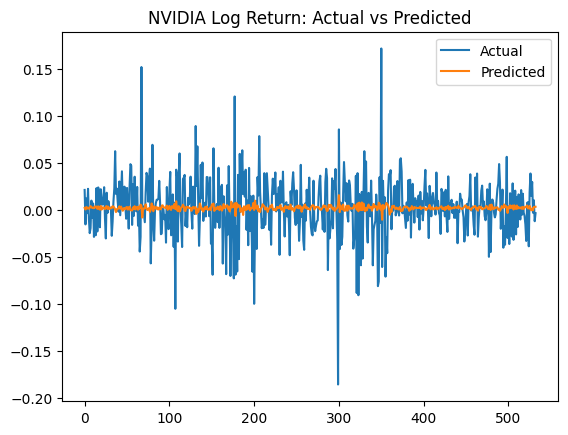

In [9]:
plt.figure()
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("NVIDIA Log Return: Actual vs Predicted")
plt.legend()
plt.show()